In [2]:
import pandas as pd


file_path = './startup data.csv'
startup_data = pd.read_csv(file_path)


startup_data.head(), startup_data.columns


(   Unnamed: 0 state_code   latitude   longitude zip_code       id  \
 0        1005         CA  42.358880  -71.056820    92101   c:6669   
 1         204         CA  37.238916 -121.973718    95032  c:16283   
 2        1001         CA  32.901049 -117.192656    92121  c:65620   
 3         738         CA  37.320309 -122.050040    95014  c:42668   
 4        1002         CA  37.779281 -122.419236    94105  c:65806   
 
             city              Unnamed: 6               name  labels  ...  \
 0      San Diego                     NaN        Bandsintown       1  ...   
 1      Los Gatos                     NaN          TriCipher       1  ...   
 2      San Diego      San Diego CA 92121              Plixi       1  ...   
 3      Cupertino      Cupertino CA 95014  Solidcore Systems       1  ...   
 4  San Francisco  San Francisco CA 94105     Inhale Digital       0  ...   
 
   object_id has_VC has_angel has_roundA  has_roundB  has_roundC  has_roundD  \
 0    c:6669      0         1     

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing: convert relevant columns to datetime
startup_data['founded_at'] = pd.to_datetime(startup_data['founded_at'], errors='coerce')
startup_data['closed_at'] = pd.to_datetime(startup_data['closed_at'], errors='coerce')
startup_data['first_funding_at'] = pd.to_datetime(startup_data['first_funding_at'], errors='coerce')
startup_data['last_funding_at'] = pd.to_datetime(startup_data['last_funding_at'], errors='coerce')

# Convert categorical columns to category type
categorical_columns = ['state_code', 'city', 'category_code', 'status']
for col in categorical_columns:
    startup_data[col] = startup_data[col].astype('category')

# Check for missing values
missing_values = startup_data.isnull().sum()


summary = startup_data.describe(include='all')

missing_values, summary


(Unnamed: 0                    0
 state_code                    0
 latitude                      0
 longitude                     0
 zip_code                      0
 id                            0
 city                          0
 Unnamed: 6                  493
 name                          0
 labels                        0
 founded_at                    0
 closed_at                   588
 first_funding_at              0
 last_funding_at               0
 age_first_funding_year        0
 age_last_funding_year         0
 age_first_milestone_year    152
 age_last_milestone_year     152
 relationships                 0
 funding_rounds                0
 funding_total_usd             0
 milestones                    0
 state_code.1                  1
 is_CA                         0
 is_NY                         0
 is_MA                         0
 is_TX                         0
 is_otherstate                 0
 category_code                 0
 is_software                   0
 is_web   

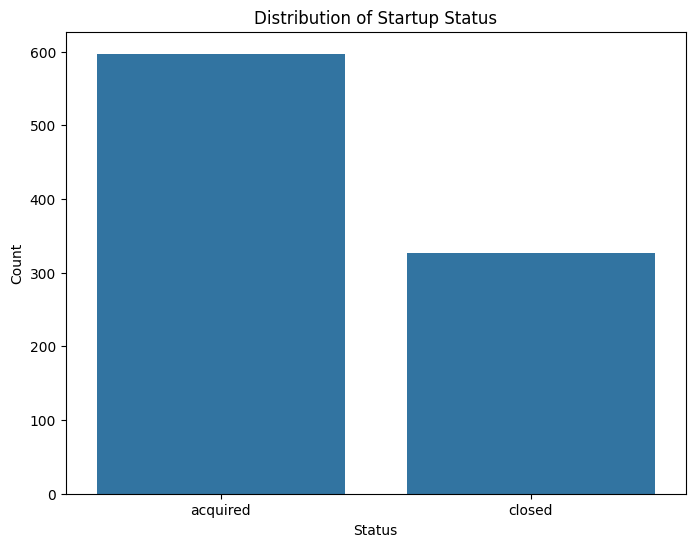

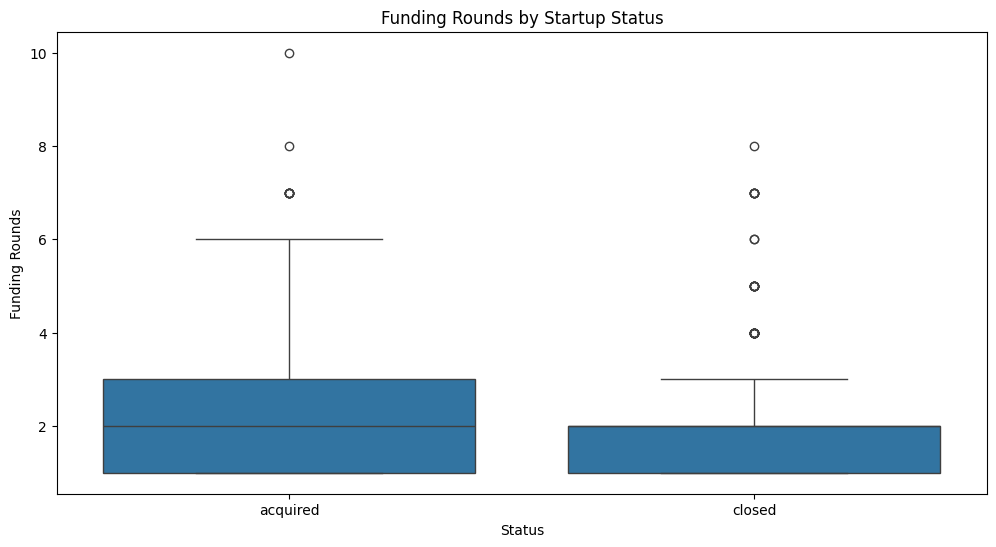

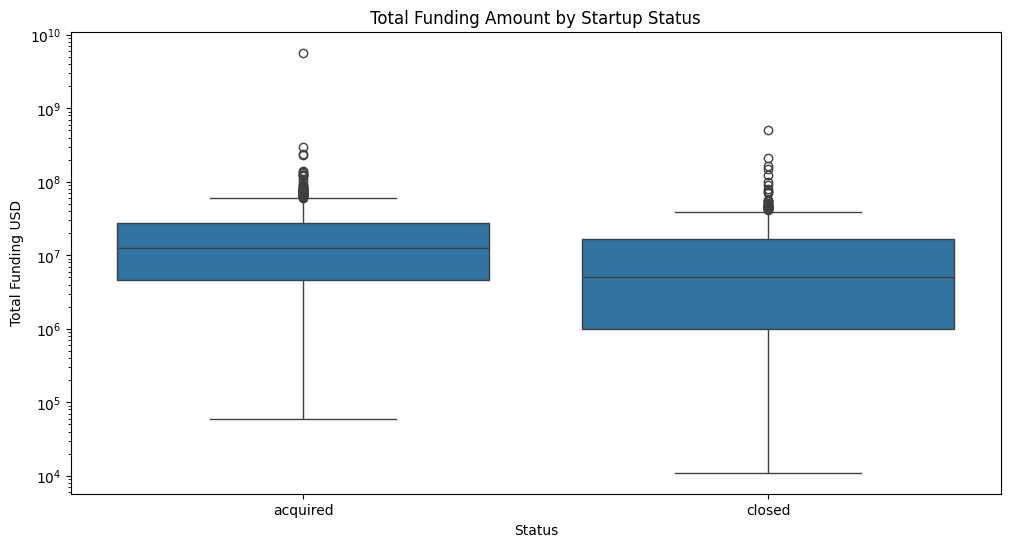

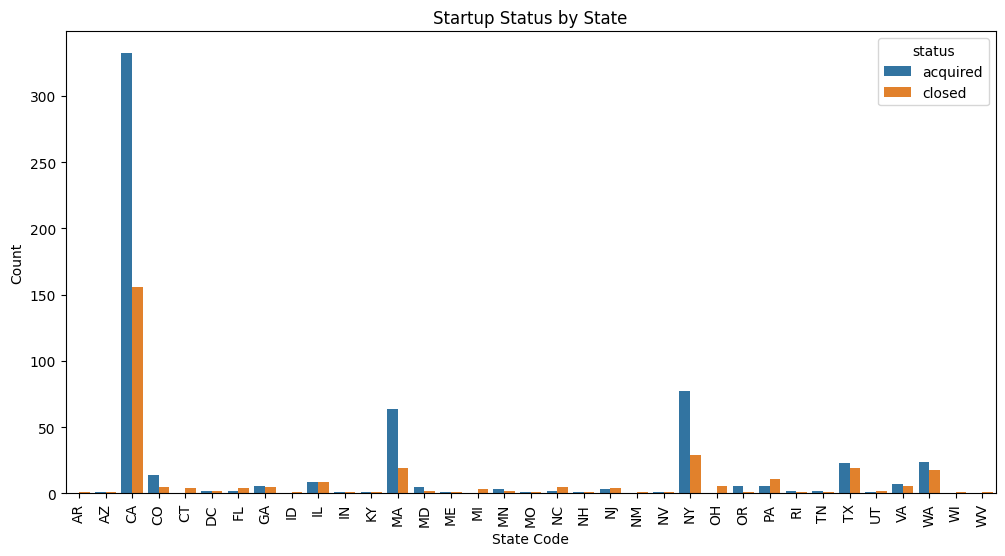

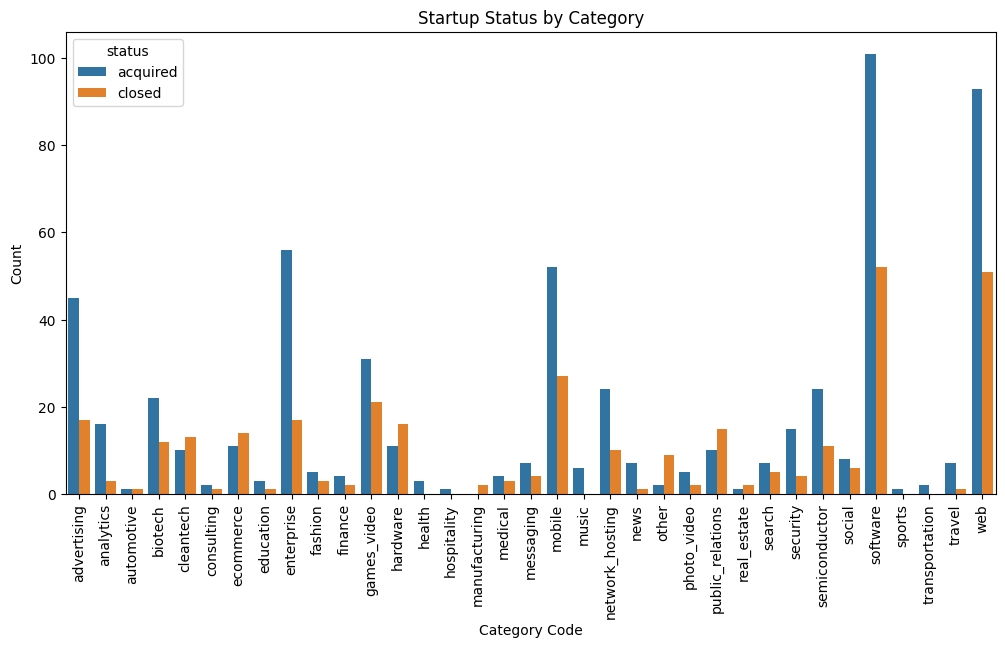

In [4]:
# Removing unnecessary columns
columns_to_drop = ['Unnamed: 0', 'id', 'object_id', 'Unnamed: 6']
startup_data_cleaned = startup_data.drop(columns=columns_to_drop)

# Handling missing values: Dropping rows where 'status' is missing
startup_data_cleaned = startup_data_cleaned.dropna(subset=['status'])

# Visualizing the distribution of status
plt.figure(figsize=(8, 6))
sns.countplot(x='status', data=startup_data_cleaned)
plt.title('Distribution of Startup Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

# Visualizing the relationship between funding rounds and status
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='funding_rounds', data=startup_data_cleaned)
plt.title('Funding Rounds by Startup Status')
plt.xlabel('Status')
plt.ylabel('Funding Rounds')
plt.show()

# Visualizing the relationship between funding total usd and status
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='funding_total_usd', data=startup_data_cleaned)
plt.title('Total Funding Amount by Startup Status')
plt.xlabel('Status')
plt.ylabel('Total Funding USD')
plt.yscale('log')  # Using log scale due to large range of values
plt.show()

# Visualizing the influence of location (state) on startup status
plt.figure(figsize=(12, 6))
sns.countplot(x='state_code', hue='status', data=startup_data_cleaned)
plt.title('Startup Status by State')
plt.xlabel('State Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Visualizing the influence of category on startup status
plt.figure(figsize=(12, 6))
sns.countplot(x='category_code', hue='status', data=startup_data_cleaned)
plt.title('Startup Status by Category')
plt.xlabel('Category Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report


file_path = './startup data.csv'  
startup_data = pd.read_csv(file_path)


columns_to_drop = ['Unnamed: 0', 'id', 'object_id', 'Unnamed: 6']
startup_data_cleaned = startup_data.drop(columns=columns_to_drop)


startup_data_cleaned = startup_data_cleaned.dropna(subset=['status'])

# Feature Engineering: Calculate the duration of operation for each startup
startup_data_cleaned['duration'] = (pd.to_datetime(startup_data_cleaned['closed_at'], errors='coerce') - pd.to_datetime(startup_data_cleaned['founded_at'], errors='coerce')).dt.days


features = ['funding_rounds', 'funding_total_usd', 'state_code', 'category_code', 'duration', 'relationships', 
            'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
target = 'status'

X = startup_data_cleaned[features]
y = startup_data_cleaned[target]


numeric_features = ['funding_rounds', 'funding_total_usd', 'duration', 'relationships']
categorical_features = ['state_code', 'category_code', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

y_train_encoded = pd.get_dummies(y_train).values
y_test_encoded = pd.get_dummies(y_test).values


model = Sequential()
model.add(Dense(64, input_dim=X_train_processed.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train_processed, y_train_encoded, epochs=50, batch_size=10, verbose=1, validation_split=0.2)

y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test accuracy: {accuracy:.2f}")

print(classification_report(y_test_classes, y_pred_classes, target_names=['acquired', 'closed']))

model.save('startup_model.h5')

# new input data (example input)
new_data = pd.DataFrame({
    'funding_rounds': [2],
    'funding_total_usd': [1000],
    'state_code': ['MA'],
    'category_code': ['ecommerce'],
    'duration': [1000],
    'relationships': [10],
    'has_VC': [0],
    'has_angel': [0],
    'has_roundA': [1],
    'has_roundB': [1],
    'has_roundC': [0],
    'has_roundD': [0]
})
new_data_processed = preprocessor.transform(new_data)
new_prediction = model.predict(new_data_processed)
new_prediction_classes = np.argmax(new_prediction, axis=1)
print(f"Prediction for new input data: {'acquired' if new_prediction_classes[0] == 0 else 'closed'}")


c:\Users\rifan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5868 - loss: 0.6564 - val_accuracy: 0.7973 - val_loss: 0.5112
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7601 - loss: 0.5137 - val_accuracy: 0.8108 - val_loss: 0.4527
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.4099 - val_accuracy: 0.8041 - val_loss: 0.4082
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8401 - loss: 0.3946 - val_accuracy: 0.8649 - val_loss: 0.3642
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8839 - loss: 0.3176 - val_accuracy: 0.8784 - val_loss: 0.3405
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8993 - loss: 0.2911 - val_accuracy: 0.8784 - val_loss: 0.3206
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9172 - loss: 0.2364 - val_accuracy: 0.8919 - val_loss: 0.2979
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9267 - loss: 0.2223 - val_accuracy: 0.8986 - val_loss:

Test accuracy: 0.88
              precision    recall  f1-score   support

    acquired       0.85      0.97      0.91       112
      closed       0.95      0.74      0.83        73

    accuracy                           0.88       185
   macro avg       0.90      0.86      0.87       185
weighted avg       0.89      0.88      0.88       185

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for new input data: acquired


In [6]:
import folium
from folium.plugins import MarkerCluster

startup_data = pd.read_csv(file_path)

location_data = startup_data[['state_code', 'latitude', 'longitude', 'name']]
location_data = location_data.dropna(subset=['latitude', 'longitude'])

#sekitar amerika
startup_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

marker_cluster = MarkerCluster().add_to(startup_map)

for idx, row in location_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

startup_map.save('./startup_locations_map.html')


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,568 (88.16 KB)

 Trainable params: 7,522 (29.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,046 (58.78 KB)

Weights shape: (83, 64)
Biases shape: (64,)


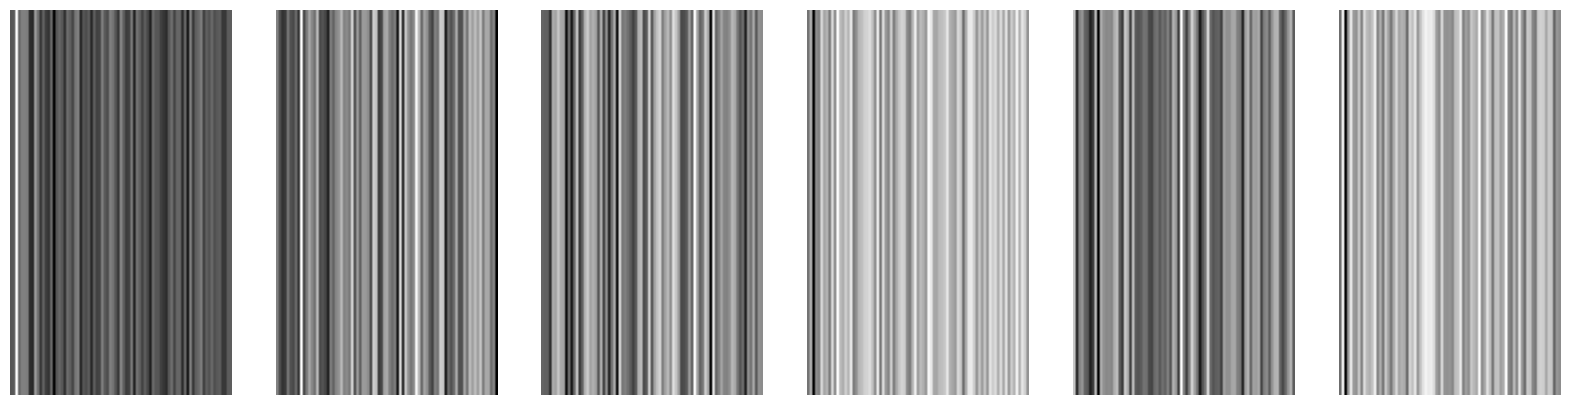

Weights shape: (64, 32)
Biases shape: (32,)


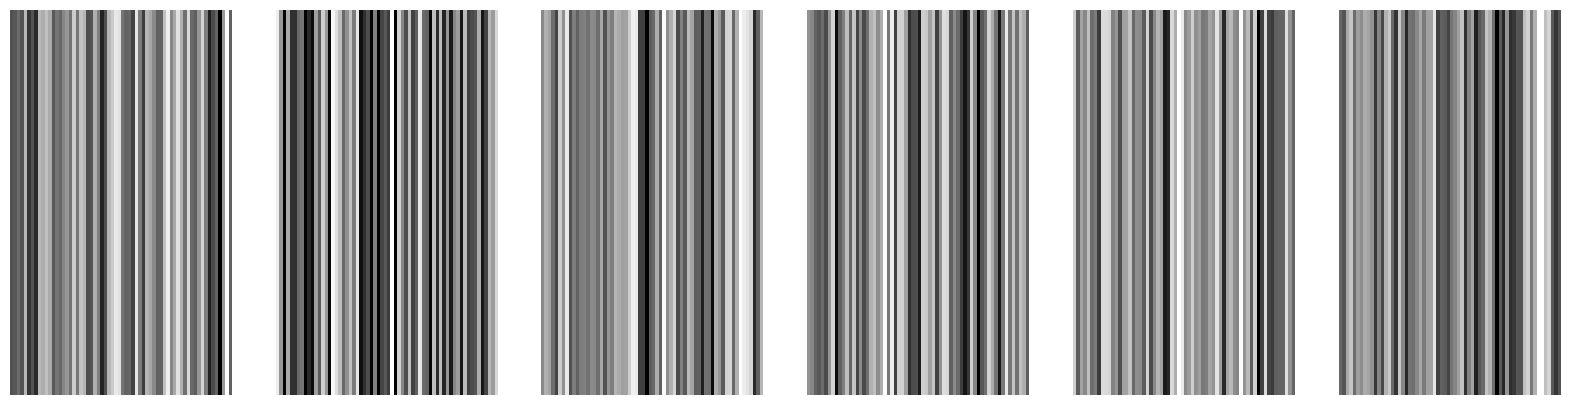

Weights shape: (32, 2)
Biases shape: (2,)


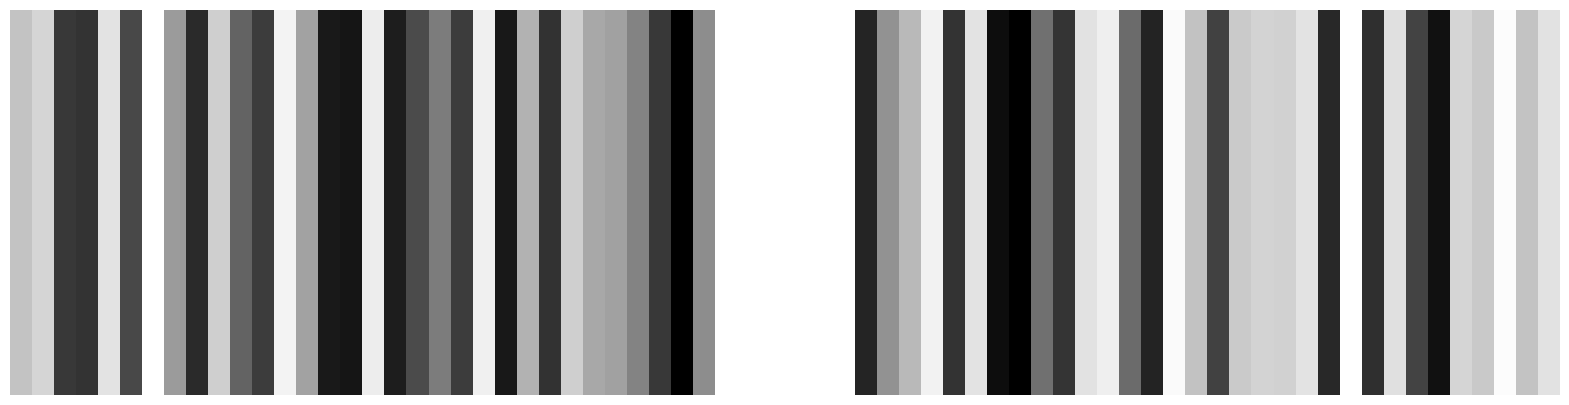

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dense_weights(layer, num_neurons=6):
    weights, biases = layer.get_weights()
    print(f"Weights shape: {weights.shape}")
    print(f"Biases shape: {biases.shape}")
    
    n_neurons = min(num_neurons, weights.shape[1])
    
    fig, axes = plt.subplots(1, n_neurons, figsize=(20, 5))
    for i in range(n_neurons):
        w = weights[:, i]
        # Normalize weight values to 0-1 for visualization
        w_min, w_max = w.min(), w.max()
        w = (w - w_min) / (w_max - w_min)
        axes[i].imshow(w.reshape((1, -1)), aspect='auto', cmap='gray')
        axes[i].axis('off')
    plt.show()


dense_layer_indices = [0, 1, 2]

for idx in dense_layer_indices:
    dense_layer = model.layers[idx]
    visualize_dense_weights(dense_layer)


Weights shape: (83, 64)
Biases shape: (64,)


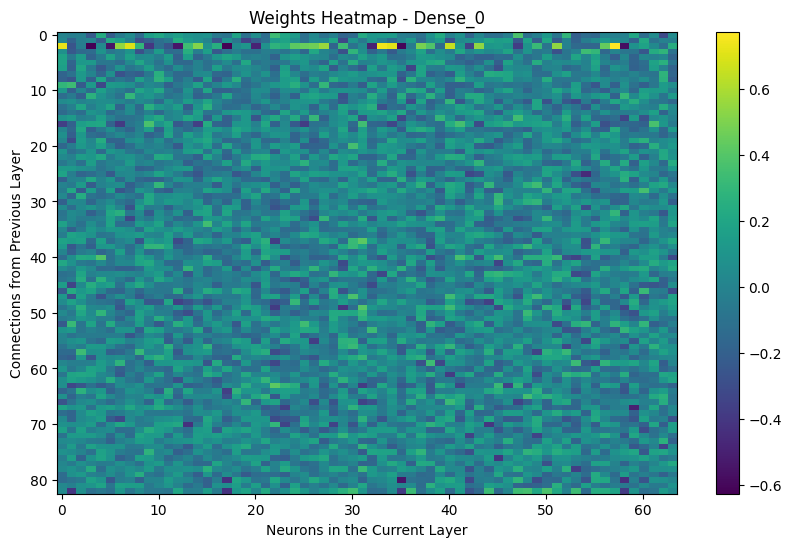

Weights shape: (64, 32)
Biases shape: (32,)


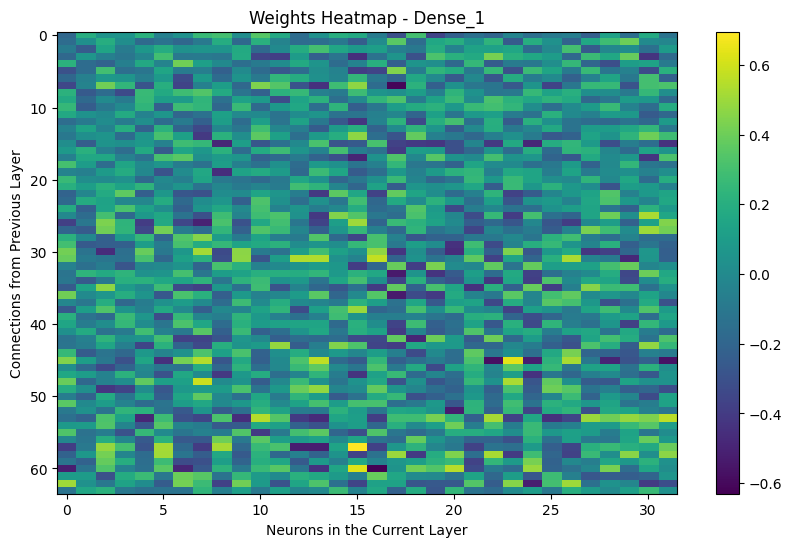

Weights shape: (32, 2)
Biases shape: (2,)


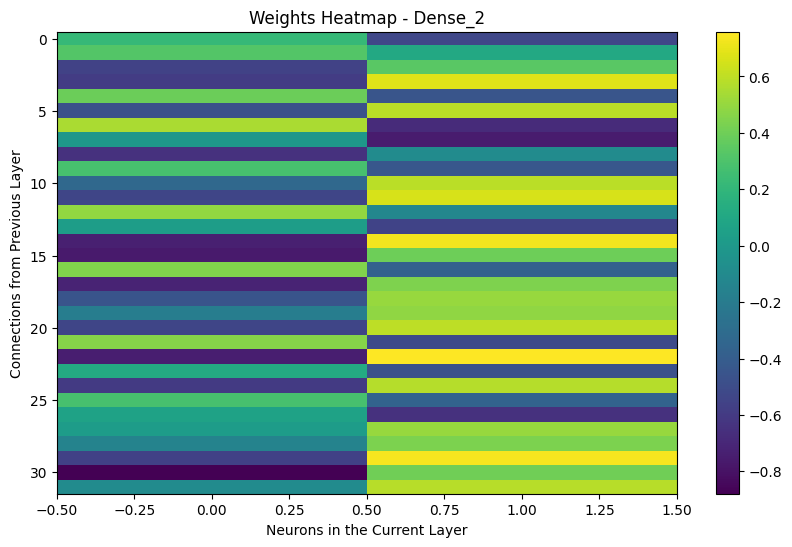

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize weights of dense layers as heatmaps
def visualize_dense_weights_heatmap(layer, layer_name):
    weights, biases = layer.get_weights()
    print(f"Weights shape: {weights.shape}")
    print(f"Biases shape: {biases.shape}")

    plt.figure(figsize=(10, 6))
    plt.title(f"Weights Heatmap - {layer_name}")
    plt.xlabel('Neurons in the Current Layer')
    plt.ylabel('Connections from Previous Layer')
    plt.imshow(weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.show()

dense_layer_indices = [0, 1, 2]
layer_names = ['Dense_0', 'Dense_1', 'Dense_2']

for idx, name in zip(dense_layer_indices, layer_names):
    dense_layer = model.layers[idx]
    visualize_dense_weights_heatmap(dense_layer, name)
